In [1]:
def check_float(textin):
    try:
        float(textin)
        return True

    except ValueError:
        return False

def check_force(folder):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    print(np.max(cleaned))
    if os.path.exists(folder+"/postProcessing/forces/{}".format(np.max(cleaned))):
        return False
    else:
        return True
    
def retrieve_lift(folder):
    import os
    import shutil
    import numpy as np
    
    files = os.listdir(folder)
    cleaned = [x for x in files if check_float(x)]
    files = sorted(cleaned)
    needs_forces = check_force(folder)
    print(needs_forces)
    if needs_forces:
        force_command = "rhoSimpleFoam -postProcess -case {} -func forces".format(folder)
        os.system(force_command)
    else:
        pass
    
    forces = np.zeros(3)
    moments = np.zeros(3)
    time = np.array([])
    fv = np.zeros(3)
    
    for file in files:    
        with open("{}/postProcessing/forces/{}/forces.dat".format(folder,file)) as f:
            full = f.readlines()
            line = full[3]
            starts = []
            ends = []
            for i in range(len(line)):
                if line[i] == '(' and line[i+1] != '(':
                    starts.append(i+1)
                elif line[i] == ')' and line[i-1] != ')':
                    ends.append(i)
            pressure_forces = np.array([float(x) for x in line[starts[0]:ends[0]].split()])
            viscous_forces = np.array([float(x) for x in line[starts[1]:ends[1]].split()])

            pressure_moments = np.array([float(x) for x in line[starts[2]:ends[2]].split()])
            viscous_moments = np.array([float(x) for x in line[starts[3]:ends[3]].split()])
            forces = np.vstack([forces, pressure_forces + viscous_forces])
            moments = np.vstack([moments, pressure_moments + viscous_moments])
            time = np.append(time,float(file))
            fv = np.vstack([fv,viscous_forces])
    return forces, moments, time, fv  
        
def massflow_bc(case_folder = './'):
    import pyvista as pv
    import numpy as np
    import os
    bool = np.bool_
    files = os.listdir(case_folder)
    files = [int(file) for file in files if check_float(file)]
    sel = max(files)
    target = case_folder + '/VTK/coandaUpper/coandaUpper_{}.vtk'.format(sel)
    raw = pv.read(target)
    points = raw.points   
    x = raw.points[:,1]
    z = raw.points[:,2]
    w = np.max(z) - np.min(z)
    p = raw.point_data['p']
    U = raw.point_data['U']
    print(U)
    T = raw.point_data['T']
    R = 287

    rho = p / (R * T)
    intRhoU = np.trapz(rho*U[:,0],x)
    mdot = intRhoU * w    
    
    return mdot


    

In [76]:
import os
import shutil
parent = '/home/james/Documents/research/completed_cases/plenum_comparison1/simple/'
dirs = os.listdir(parent)

# for item in dirs:
#     target = parent+item
#     shutil.rmtree(target+'/postProcessing/')
#     print("Removing postProcessing folder from {}".format(target))

# for item in dirs:
#     target = parent + item + '/system/forces'
#     with open(target,'r') as f:
#         lines = f.readlines()
#         f.close()
#     newline = '    patches\t  ("surface" "coandaUpper" "coandaLower");\n'
#     lines[18] = newline
#     with open(target,'w') as f:
#         f.writelines(lines)
#         f.close
        


0.13649421314233143
0.31677474454326643
0.23976956589399676
0.33347320238897427
0.16271975164250665


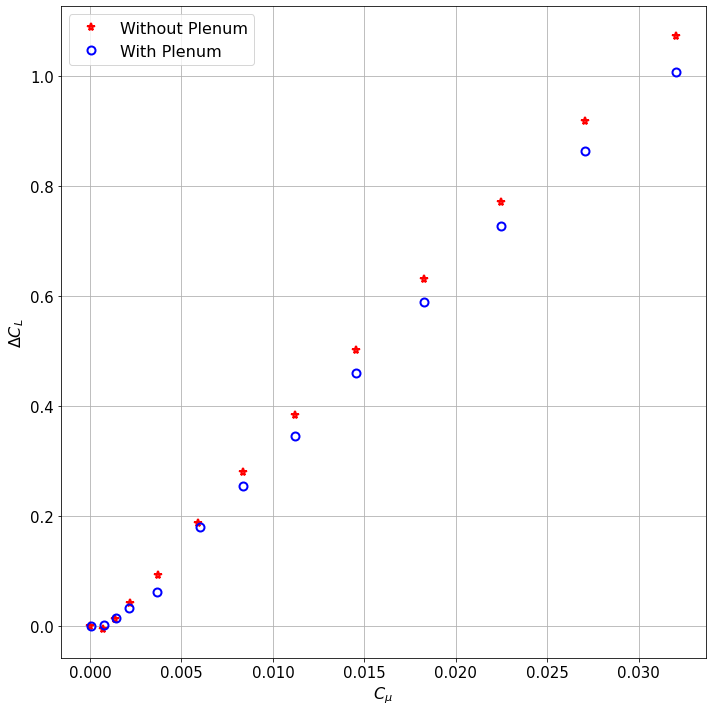

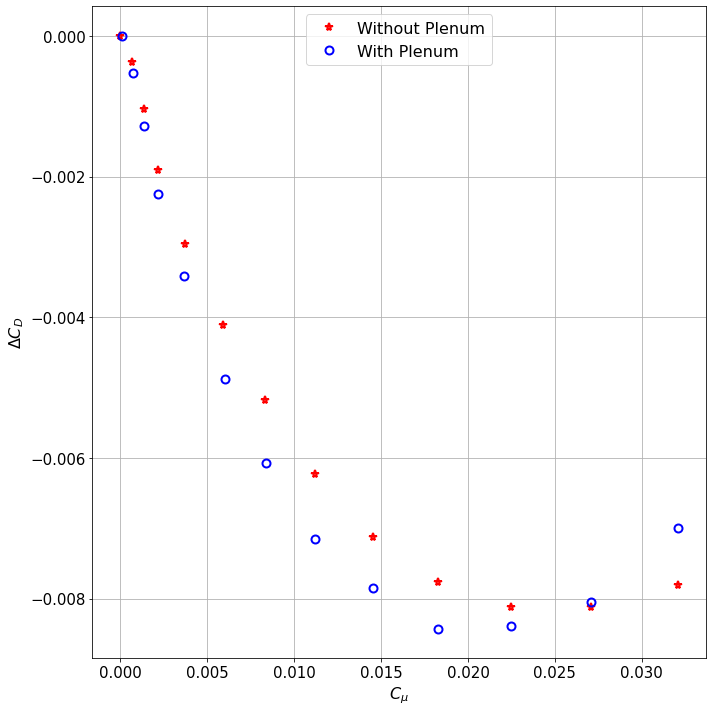

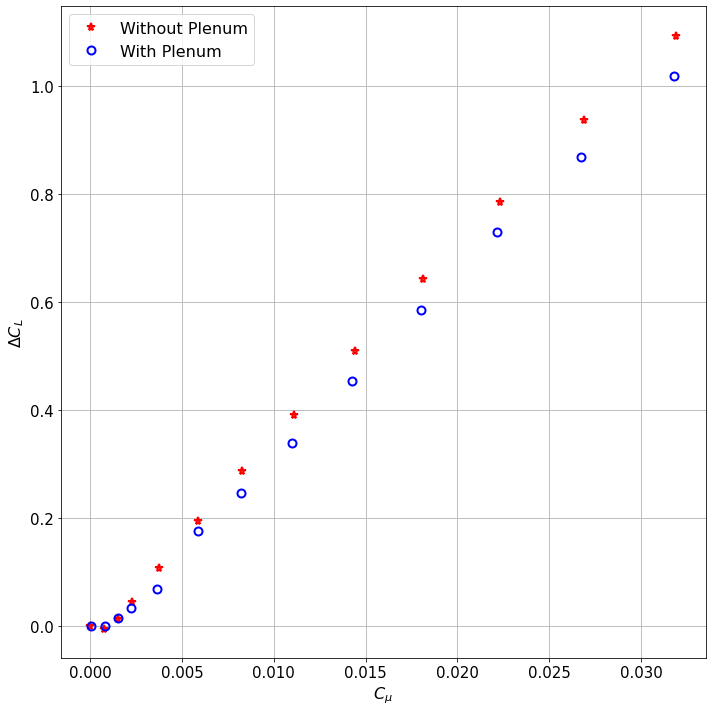

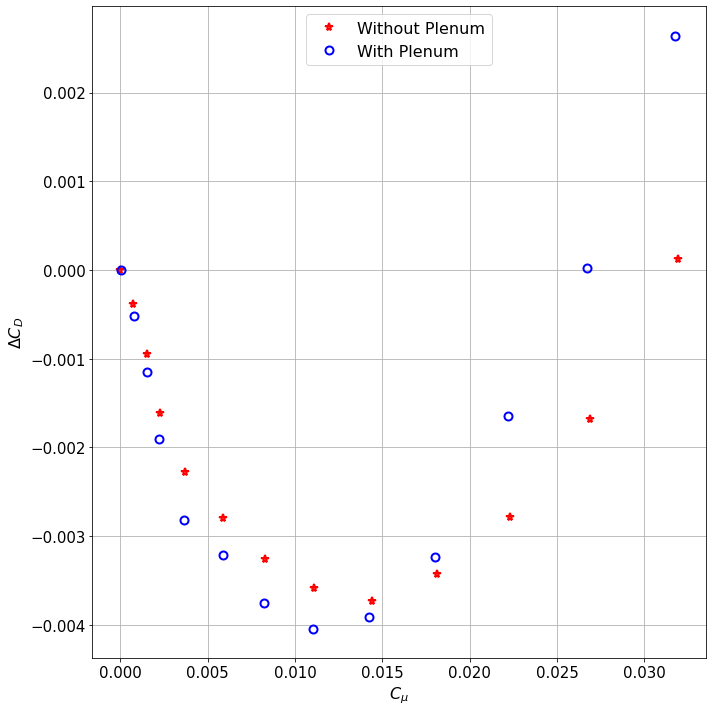

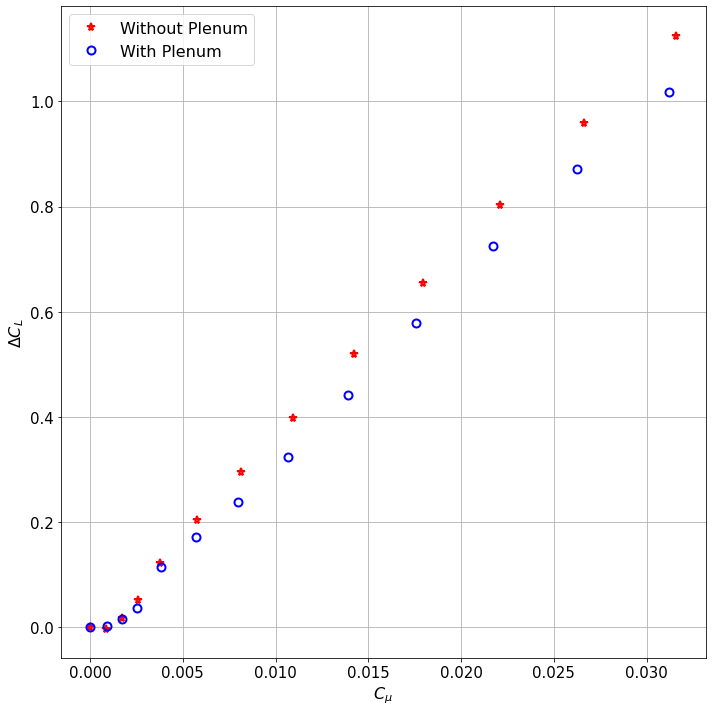

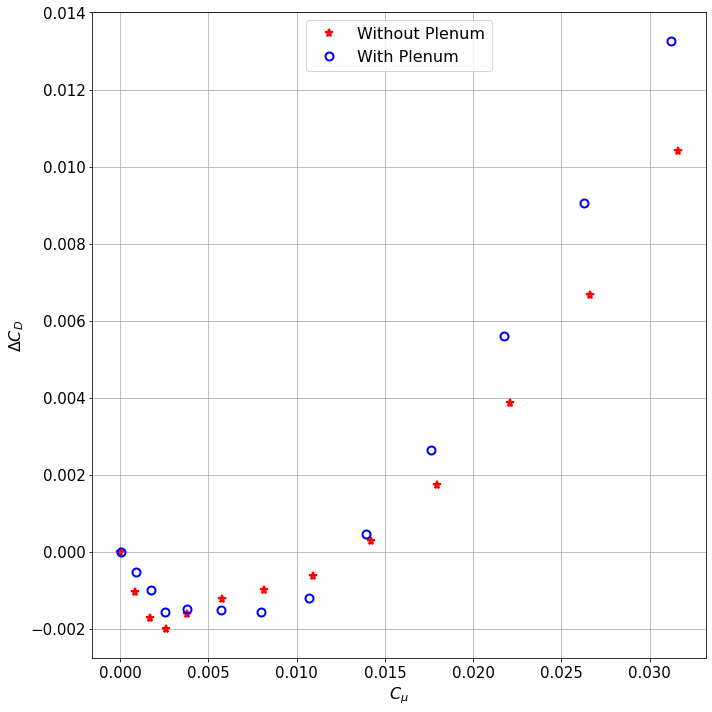

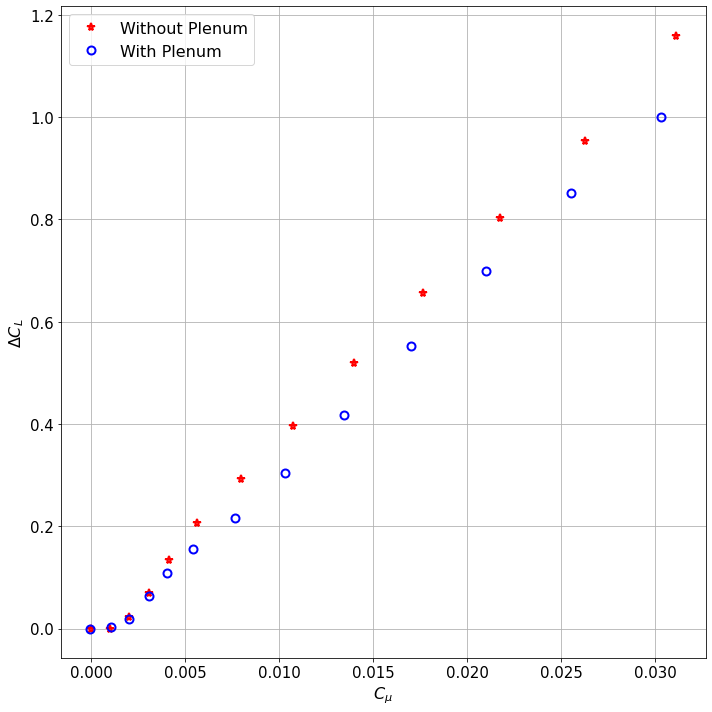

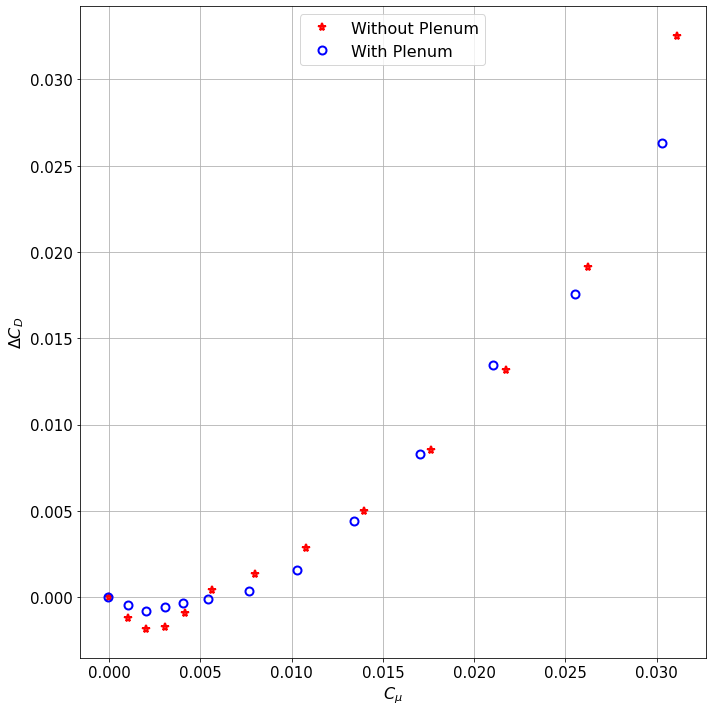

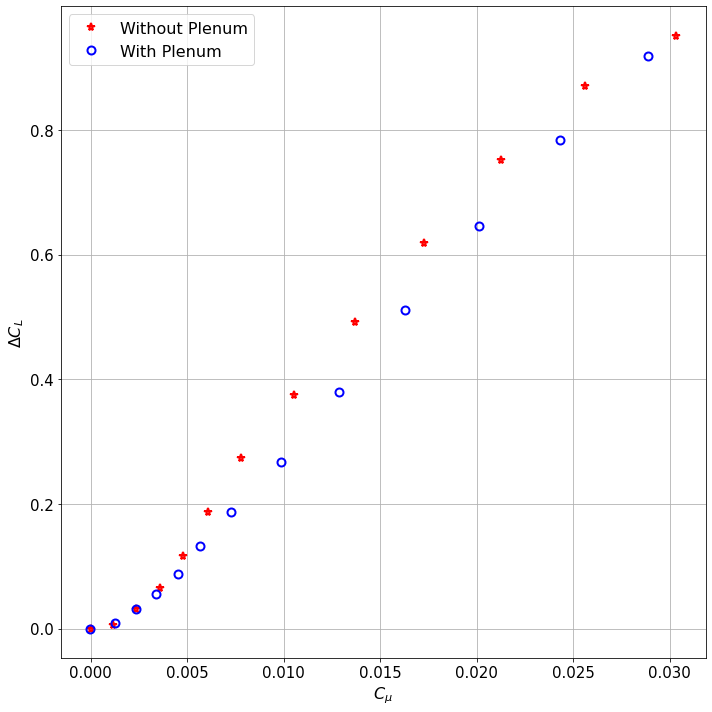

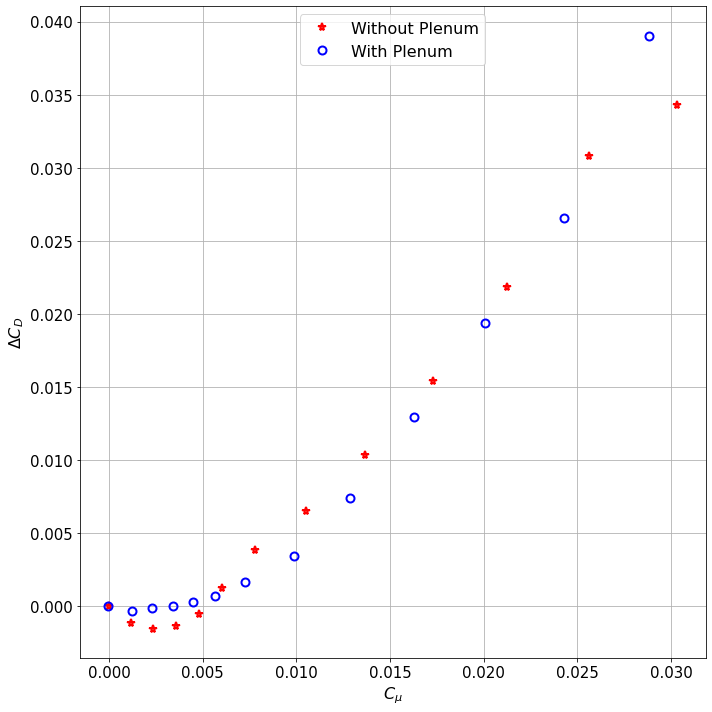

In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
from processing import *
from bezier_foil import *

parent = '/home/james/Documents/research/completed_cases/plenum_comparison1/'

vom = 24.1/0.001

meanflow = 32.4074
c = 0.3
b = 0.156
rho = 1.17

QS = 0.5 * meanflow ** 2 * rho * c * b
aoas = np.arange(0,10.1,2.5)
mdots = np.arange(0,0.0061,0.0005)
M = len(aoas)
N = len(mdots)

lifts = np.zeros([M,N,2])
drags = np.zeros([M,N,2])
CL = np.zeros([M,N,2])
CD = np.zeros([M,N,2])
mdotspl = np.zeros(N)
cmupl = np.zeros(N)
cmusi = np.zeros(N)
sep = np.zeros([M,N,2])

for i in range(M):
    aoa = aoas[i]
    alpha = aoa * np.pi / 180
    for j in range(N):
        target_pl = parent + '/plenum/aoa{}_mdot{}/'.format(aoas[i],round(mdots[j],4))
        F,M,tt,fvpl = retrieve_lift(target_pl)
        vjetpl = max_velocity(target_pl)        
        pl_thrust = thrust_pbc(case_folder=target_pl)
#         print('mdot: {}, thrust: {}'.format(mdots[j],pl_thrust))
        lifts[i,j,1] = F[-1,1] * np.cos(alpha) - (F[-1,0]-pl_thrust) * np.sin(alpha)
        drags[i,j,1] = (F[-1,0]-pl_thrust) * np.cos(alpha) + F[-1,1] * np.sin(alpha)
        fvpl = fvpl[-1,0]
        sep[i,j,1] = separation_angle_find(case_folder=target_pl)
        
        mdotspl[j] = massflow_bc(target_pl)
        cmupl[j] = mdotspl[j]*vjetpl / QS
        target_si = parent + '/simple/aoa{}_mdot{}/'.format(aoas[i],round(mdots[j],4))
        F,Mm,tt,fvsi = retrieve_lift(target_si)
        fvsi = fvsi[-1,0]
        try:
            vjet = max_velocity(target_si)
        except:
            print(target_si)
        if vjet < 45:
            vjet = vom * mdots[j]
        else:
            vjet = vjet
        cmusi[j] = mdots[j]*vjetpl / QS
        lifts[i,j,0] = F[-1,1] * np.cos(alpha) - (F[-1,0]-mdots[j]*vjet) * np.sin(alpha)
        drags[i,j,0] = (F[-1,0]-mdots[j]*vjet) * np.cos(alpha) + F[-1,1] * np.sin(alpha)
        sep[i,j,0] = separation_angle_find(case_folder=target_si)
        
        CL[i,j,:] = (lifts[i,j,:] - lifts[i,0,:]) / QS
        CD[i,j,:] = (drags[i,j,:] - drags[i,0,:]) / QS
        
        
#         if aoa == 0:
#             print("D_diff: {}, visc_diff: {}".format(CD[i,j,1]-CD[i,j,0],(fvpl-fvsi)/QS))
    
    plt.figure(figsize=[10,10])
    plt.plot(cmusi,CL[i,:,0],'r*',cmupl,CL[i,:,1],'bo',markersize=8,mfc='none',mew=2)
    plt.legend(['Without Plenum','With Plenum'],fontsize=16,loc='upper left')
    plt.xlabel(r'$C_\mu$',fontsize=16)
    plt.ylabel(r'$\Delta C_L$',fontsize=16)
    plt.tick_params(labelsize=15)
    plt.grid()
    plt.tight_layout()
    
#     plt.savefig('/home/james/Documents/research/thesis/cfd_plenum_compare_aoa{}_cl.png'.format(aoa))
    
    plt.figure(figsize=[10,10])
    plt.plot(cmusi,CD[i,:,0],'r*',cmupl,CD[i,:,1],'bo',markersize=8,mfc='none',mew=2)
    plt.legend(['Without Plenum','With Plenum'],fontsize=16,loc='upper center')
    plt.xlabel(r'$C_\mu$',fontsize=16)
    plt.ylabel(r'$\Delta C_D$',fontsize=16)
    plt.tick_params(labelsize=15)
    plt.grid()
    
    plt.tight_layout()
    plt.savefig('/home/james/Documents/research/thesis/cfd_plenum_compare_aoa{}_cd_novisc.png'.format(aoa))
    print(np.max(abs(CD[i,:,0]-CD[i,:,1]))/(drags[i,0,0]/QS))
#     print(drags[i,0,:]/QS)
    

CD = drags / QS
        



41
108191.24163663764


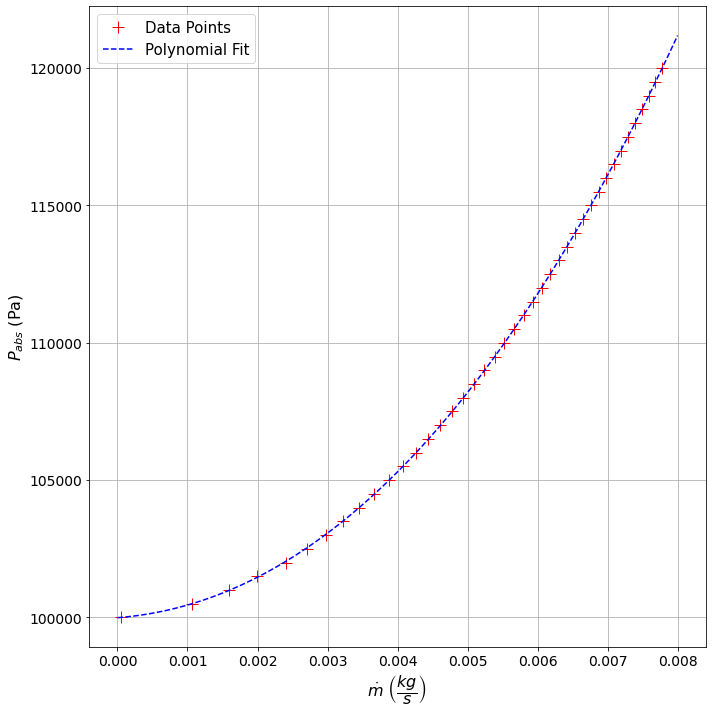

In [9]:
import numpy as np
from matplotlib import pyplot as plt

mdot = np.loadtxt('./output/mdot.txt')
pin = np.loadtxt('./output/pressure.txt')

fit = np.polyfit(mdot,pin,3)
x = np.linspace(0,0.008,101)
y = np.polyval(fit,x)
print(len(pin))

plt.figure(figsize=[10,10])
plt.plot(mdot,pin,'r+',markersize=12)
plt.plot(x,y,'b--',markersize=4)
plt.ylabel(r'$P_{abs}$ (Pa)',fontsize=16)
plt.xlabel(r'$\dot{m}$ $\left(\dfrac{kg}{s}\right)$',fontsize=16)
plt.legend(['Data Points','Polynomial Fit'],fontsize=15)
plt.tick_params(labelsize=14)
plt.grid()
plt.tight_layout()
plt.savefig('/home/james/Documents/research/thesis/plenum_press_vs_mdot.png')

print(np.polyval(fit,0.005))

In [21]:
import numpy as np

def sep_angle(r,p):
    import numpy as np
    pexit = np.array([-r,r])
    L = np.linalg.norm(pexit-p)
    theta = 2 * np.arcsin((0.5*L)/r) * 180 / np.pi
    return theta

r = 0.003048
ppl = np.array([-2.75851e-5,0.000409143])
psi = np.array([-1.227e-5,0.000273])
np.linalg.norm(pexit-ppl)

thetapl = 2 * np.arcsin((0.5*np.linalg.norm(pexit-ppl))/r)
thetasi = 2 * np.arcsin((0.))

print(sep_angle(r,psi),sep_angle(r,ppl))
print(massflow_bc('./'))

print(0.005 * 123.4 / (0.5 * 1.17 * .156 * .3 * 40**2))

84.86094018740167 82.28571468187282
0.005018392
0.014085214405727228


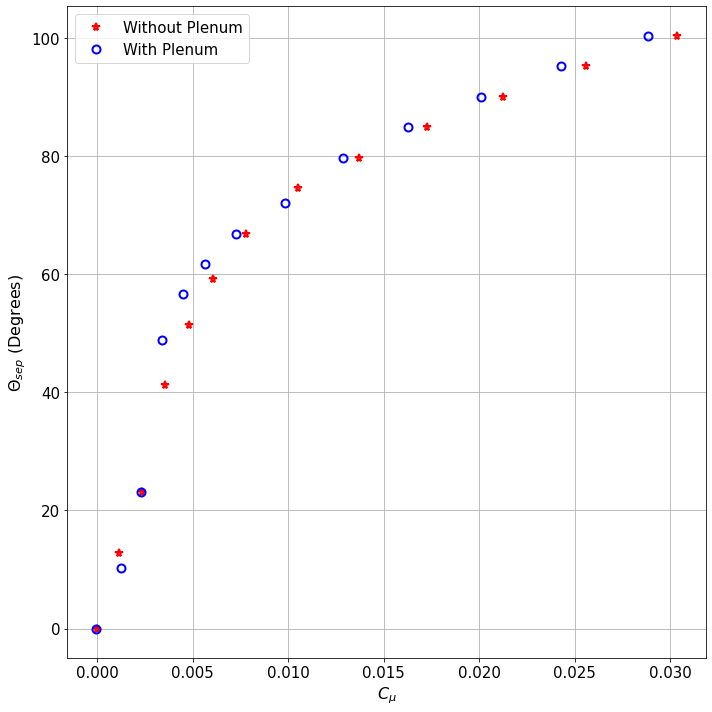

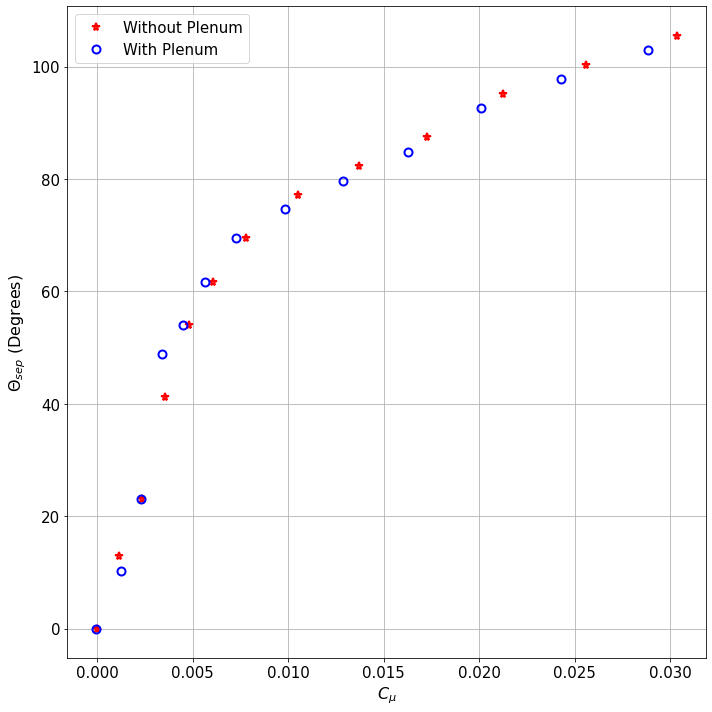

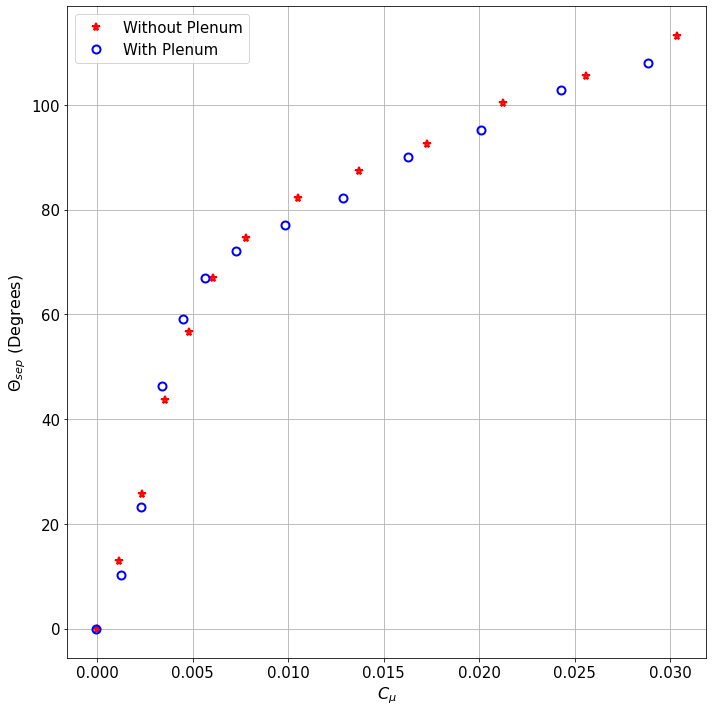

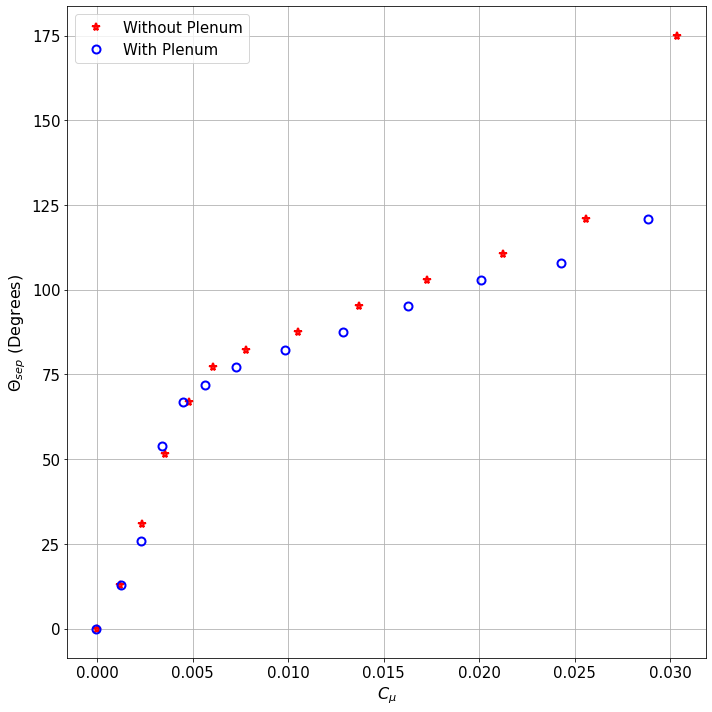

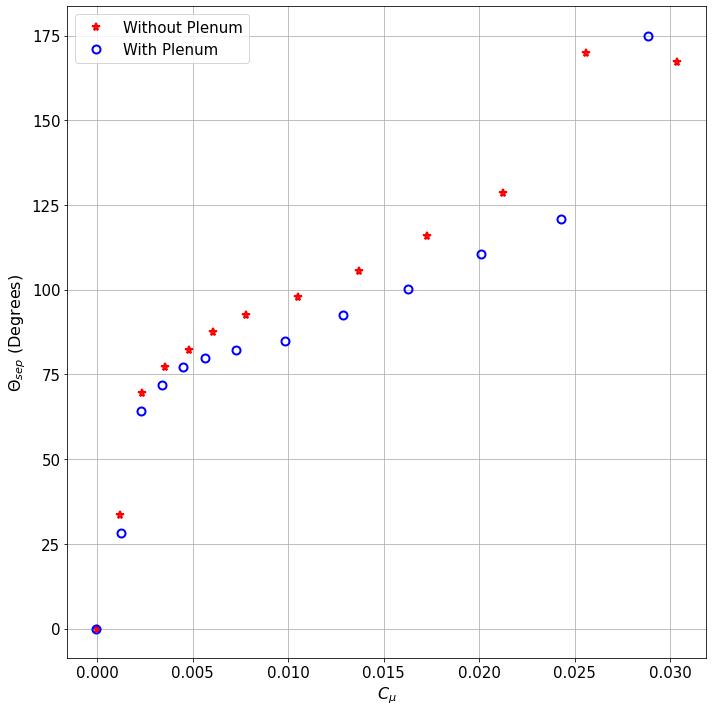

In [6]:

for i in range(len(aoas)):
    plt.figure(figsize=[10,10])
    sep[i,0,0] = 0
    sep[i,0,1] = 0
    plt.plot(cmusi,sep[i,:,0],'r*',cmupl,sep[i,:,1],'bo',markersize=8,mfc='none',mew=2)
    plt.ylabel(r'$\Theta_{sep}$ (Degrees)',fontsize=16)
    plt.xlabel(r'$C_\mu$',fontsize=16)
    plt.legend(['Without Plenum','With Plenum'],fontsize=15)
    plt.tick_params(labelsize=15)
    plt.tight_layout()
    plt.grid()
    plt.savefig('./output/cfd_separation_aoa{}.png'.format(aoas[i]))